# Context : Feature selection


Source : 


**Competition Description**
xxxx


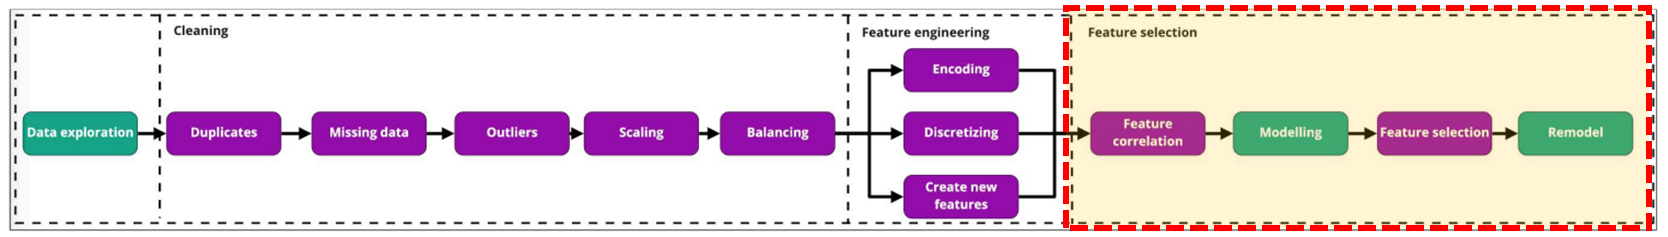


# Imports


In [1]:
import warnings
warnings.filterwarnings(action = 'ignore')

import os
import time
import pickle

import pandas as pd
pd.options.display.max_columns = None
import numpy as np
from scipy.stats import iqr

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix

# Imputers, scalers, encoders
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder

# Pipelines, transformers
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import make_union
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import FunctionTransformer

# Models
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge

# Inspection
from sklearn.inspection import permutation_importance

from sklearn.metrics import mean_squared_error

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve


# Retrieve data


## Get the raw data


In [2]:
#Retrieve data
path_to_data = '../data/raw_data/'
data = pd.read_csv(path_to_data + 'train.csv')
print(data.shape)
data.head(3)

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


## Drop duplicates in rows


In [3]:
# Columns in which na rows must be dropped :
missing_rows_to_drop = ['MasVnrType','Electrical']

# Drop Columns in which na rows
print(f"Shape of data before : {data.shape}")
      
for col in missing_rows_to_drop:
    data.dropna(subset=col, axis=0, inplace=True)
      
print(f"Shape of data after : {data.shape}")


Shape of data before : (1460, 81)
Shape of data after : (1451, 81)


## Train test split


### General


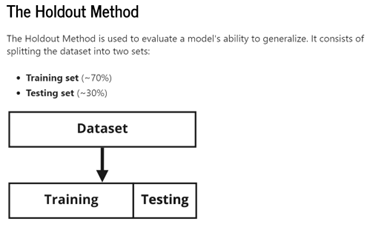



In [4]:
# Define target name
target_name = 'SalePrice'

In [5]:
# Define X and y
X = data.drop(columns= target_name)
y = data[target_name]

In [6]:
# Separating train set from test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Display shapes
print(f"Shape of X_train : {X_train.shape}")
print(f"Shape of X_test : {X_test.shape}")
print(f"Shape of y_train : {y_train.shape}")
print(f"Shape of y_test : {y_test.shape}")

Shape of X_train : (1015, 80)
Shape of X_test : (436, 80)
Shape of y_train : (1015,)
Shape of y_test : (436,)


In [7]:
X_train.head()


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
713,714,190,RL,60.0,9873,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,BrkSide,RRAn,Norm,2fmCon,1Story,4,5,1970,1970,Gable,CompShg,HdBoard,HdBoard,BrkFace,160.0,TA,TA,CBlock,TA,TA,Av,ALQ,789,Unf,0,171,960,GasW,TA,N,SBrkr,960,0,0,960,1,0,1,0,3,1,TA,6,Typ,0,NaN,Detchd,1970.0,Unf,2,576,TA,TA,Y,0,288,0,0,0,0,NaN,NaN,NaN,0,5,2006,WD,Normal
623,624,160,FV,NaN,2117,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,TwnhsE,2Story,6,5,2000,2000,Gable,CompShg,MetalSd,MetalSd,BrkFace,513.0,Gd,TA,PConc,Gd,TA,No,GLQ,420,Unf,0,336,756,GasA,Ex,Y,SBrkr,756,756,0,1512,0,0,2,1,2,1,Gd,4,Typ,1,TA,Detchd,2000.0,Unf,2,440,TA,TA,Y,0,32,0,0,0,0,NaN,NaN,NaN,0,6,2007,WD,Normal
592,593,20,RL,60.0,6600,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5,8,1982,2003,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,Gd,PConc,TA,Gd,No,GLQ,816,Unf,0,0,816,GasA,Ex,Y,SBrkr,816,0,0,816,1,0,1,0,2,1,TA,4,Typ,0,NaN,Detchd,1985.0,Fin,2,816,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,6,2008,WD,Normal
631,632,120,RL,34.0,4590,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,Twnhs,1Story,8,5,2006,2006,Gable,CompShg,VinylSd,VinylSd,Stone,108.0,Gd,TA,PConc,Gd,Gd,Mn,GLQ,24,Unf,0,1530,1554,GasA,Ex,Y,SBrkr,1554,0,0,1554,0,0,2,0,2,1,Gd,6,Typ,1,Gd,Attchd,2006.0,RFn,2,627,TA,TA,Y,156,73,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal
158,159,60,FV,100.0,12552,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,Somerst,Norm,Norm,1Fam,2Story,7,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,None,0.0,Gd,TA,PConc,Gd,TA,No,GLQ,222,Unf,0,769,991,GasA,Ex,Y,SBrkr,991,956,0,1947,0,0,2,1,3,1,Gd,8,Typ,1,Gd,Attchd,2004.0,RFn,2,678,TA,TA,Y,0,136,0,0,0,0,NaN,GdWo,NaN,0,5,2010,WD,Normal


In [8]:
y_train.head()

713    129000
623    168500
592    138000
631    209500
158    254900
Name: SalePrice, dtype: int64

### Create validation set


In [9]:
# # Separating train set from validation set
# X_train_no_val, X_val, y_train_no_val, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# # Display shapes
# print(f"Shape of X_train_no_val : {X_train_no_val.shape}")
# print(f"Shape of X_val : {X_val.shape}")
# print(f"Shape of y_train_no_val : {y_train_no_val.shape}")
# print(f"Shape of y_val : {y_val.shape}")

## Create pipeline



In [10]:
# Load Pipeline from pickle file
preprocessing_pipeline = pickle.load(open("../data/pipeline.pkl","rb"))

In [11]:
# Estimate an optimum number of features to keep after feature selection (roughly 20% of the total number of features after preprocessing using PARETO principle)
preprocessing_pipeline.set_output(transform="pandas")
preprocessing_pipeline.fit_transform(X_train).shape[1]*0.2

45.6

In [12]:
#Create pipeline
pipe = Pipeline([('preproc', preprocessing_pipeline),
                 ('selector', SelectKBest(score_func = mutual_info_regression, k=45)),
                 ('classifier', LinearRegression())])
pipe;

# Modelling

## Grid Search


In [13]:
param_grid = [
                {'selector__k': [10, 20, 30, 40]},
                {'classifier': [LinearRegression()]},
                {
                    'classifier': [SGDRegressor()],
                    'classifier__alpha' : [0.001, 0.01, 0.1, 1]
                },
                {
                    'classifier': [Lasso()], 
                    'classifier__alpha' : [1, 2, 3, 4]
                },
                {
                    'classifier': [ElasticNet()],
                    'classifier__alpha' : [1, 2, 3, 4]
                },
                {
                    'classifier': [SVR()],
                    'classifier__C' : [1, 1/2, 1/3, 1/4]
                },
                {
                    'classifier': [GradientBoostingRegressor()],                
                    'classifier__n_estimators' : [100, 125, 150, 175]
                },
                {'classifier': [RandomForestRegressor()]},
                {
                    'classifier': [Ridge()],
                    'classifier__alpha' : [1, 2, 3, 4]
                }
            ]

# Scoring method
scoring = 'neg_mean_squared_error'

grid_search = GridSearchCV(
                            estimator = pipe,
                            param_grid = param_grid,
                            scoring = scoring,
                            n_jobs = -1,
                            refit=True,
                            cv = 5,
                            verbose=0
                        )

In [14]:
grid_search.fit(X_train, y_train);

/home/thierry/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [2, 5, 9, 14, 18, 22] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/thierry/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [2, 5, 9, 14, 18, 22] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/thierry/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [14, 16] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/thierry/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [4, 9, 1

/home/thierry/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [2, 5, 9, 14, 18, 22] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/thierry/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [4, 9, 14, 22] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/thierry/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [2, 9, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/thierry/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [14, 16] duri

/home/thierry/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [14, 16] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/thierry/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [5, 10, 11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/thierry/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [4, 9, 14, 22] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/thierry/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [2, 5, 9, 14, 18, 22] dur

/home/thierry/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [4, 9, 14, 22] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/thierry/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [2, 9, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/thierry/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [14, 16] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/thierry/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [5, 10, 11] during transfo

/home/thierry/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [2, 5, 9, 14, 18, 22] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/thierry/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [4, 9, 14, 22] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/thierry/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [2, 5, 9, 14, 18, 22] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/thierry/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [4

In [15]:
grid_search.best_params_

{'classifier': GradientBoostingRegressor(), 'classifier__n_estimators': 100}

In [16]:
grid_search.best_estimator_

Pipeline(steps=[('preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('drop', 'drop',
                                                  ['Id', 'PoolQC',
                                                   'MiscFeature', 'Alley']),
                                                 ('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='NA',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Fence', 'GarageTy...
                                                  OrdinalEncoder(categories=[['Po',
                                                                              'Fa',
                                                                              'TA',
                                                                              'Gd',
                                                                              'Ex'],
                                                                             ['Po',
                                                                              'Fa',
                                                                              'TA',
                                                                              'Gd',
                                                                              'Ex'],
                                                                             ['Po',
                                                                              'Fa',
                                                                              'TA',
                                                                              'Gd',
                                                                              'Ex'],
                                                                             ['Po',
                                                                              'Fa',
                                                                              'TA',
                                                                              'Gd',
                                                                              'Ex']]),
                                                  ['HeatingQC', 'ExterQual',
                                                   'KitchenQual',
                                                   'ExterCond'])],
                                   verbose_feature_names_out=False)),
                ('selector',
                 SelectKBest(k=45,
                             score_func=<function mutual_info_regression at 0x7fcff7f5bd90>)),
                ('classifier', GradientBoostingRegressor())])

In [17]:
# Keep best model
best_mdl = grid_search.best_estimator_

## Check underfitting/Overfitting


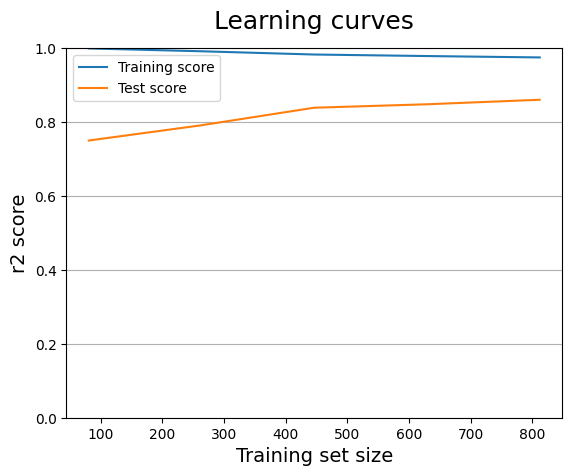

In [18]:
# Get train scores (R2), train sizes, and validation scores using `learning_curve`
train_sizes, train_scores, test_scores = learning_curve(
                                                        estimator=best_mdl, 
                                                        X = X_train,
                                                        y = y_train,
                                                        # train_sizes=train_sizes,
                                                        cv=5)

# Take the mean of cross-validated train scores and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, label = 'Training score')
plt.plot(train_sizes, test_scores_mean, label = 'Test score')
plt.ylabel('r2 score', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves', fontsize = 18, y = 1.03)
plt.grid(visible = True, which='major', axis='y')
plt.ylim(0,1)
plt.legend()


# Evaluate on test set


In [19]:
# Instantiate, and fit linear regression model
# chosen_mdl = RandomForestRegressor()
best_mdl.fit(X_train, y_train)

Pipeline(steps=[('preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('drop', 'drop',
                                                  ['Id', 'PoolQC',
                                                   'MiscFeature', 'Alley']),
                                                 ('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='NA',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Fence', 'GarageTy...
                                                  OrdinalEncoder(categories=[['Po',
                                                                              'Fa',
                                                                              'TA',
                                                                              'Gd',
                                                                              'Ex'],
                                                                             ['Po',
                                                                              'Fa',
                                                                              'TA',
                                                                              'Gd',
                                                                              'Ex'],
                                                                             ['Po',
                                                                              'Fa',
                                                                              'TA',
                                                                              'Gd',
                                                                              'Ex'],
                                                                             ['Po',
                                                                              'Fa',
                                                                              'TA',
                                                                              'Gd',
                                                                              'Ex']]),
                                                  ['HeatingQC', 'ExterQual',
                                                   'KitchenQual',
                                                   'ExterCond'])],
                                   verbose_feature_names_out=False)),
                ('selector',
                 SelectKBest(k=45,
                             score_func=<function mutual_info_regression at 0x7fcff7f5bd90>)),
                ('classifier', GradientBoostingRegressor())])

In [20]:
final_predictions = best_mdl.predict(X_test)
final_predictions_df = pd.DataFrame(final_predictions, index=y_test.index)
final_predictions_df.head()


,0
540,348764.473831
757,160163.447196
49,128713.570146
1456,204633.119333
141,238236.531145


In [21]:
pd.merge(final_predictions_df.reset_index(), y_test.reset_index())

,index,0,SalePrice
0,540,348764.473831,315000
1,757,160163.447196,158900
2,49,128713.570146,127000
3,1456,204633.119333,210000
4,141,238236.531145,260000
...,...,...,...
431,135,175279.406279,174000
432,1185,124250.928142,104900
433,1452,116177.181505,145000
434,1140,128720.324910,139000


In [22]:
# Compute root mean squared error
final_rmse = mean_squared_error(y_test,final_predictions, squared=False )
final_rmse

28067.468264208645

In [23]:
# Confidence interval
from scipy import stats
confidence = 0.95
squared_errors = (final_predictions - y_test)**2
np.sqrt(stats.t.interval(   confidence, 
                            len(squared_errors) - 1, 
                            loc=squared_errors.mean(),
                           scale=stats.sem(squared_errors)
                       )
        )

array([10390.67850209, 38309.25932188])